# House Price Prediction

### Introduction

The dataset provided contains a set of variables that could determine the housing prices in a locality . The challenge here is to build a model which could predict the prices accurately . Its a classic regression problem and the metric to be used here is RMSE score as per the competition page . We have been provided with the train and test dataset to play with . Lets get started.

### Loading the required libraries and dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import gc
import datetime as dt
warnings.filterwarnings('ignore')
%matplotlib inline

### Modelling:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


Going by the description of the dataset I see that most of the columns should be of categorical datatype . I create a custom dictionary to define the datatypes and read the dataset assigning this datatype.

In [2]:
dtypes = {'Id':'int64',
         'MSSubClass':'category',
         'MSZoning':'category',
         'LotFrontage':'object',
         'LotArea':'float64',
         'Street':'category',
         'Alley':'category',
         'LotShape':'category',
         'LandContour':'category',
         'Utilities':'category',
         'LotConfig':'category',
         'LandSlope':'category',
         'Neighborhood':'category',
         'Condition1':'category',
         'Condition2':'category',
         'BldgType':'category',
         'HouseStyle':'category',
         'OverallQual':'category',
         'OverallCond':'category',
         'YearBuilt':'int64',
         'YearRemodAdd':'int64',
         'RoofStyle':'category',
         'RoofMatl':'category',
         'Exterior1st':'category',
         'Exterior2nd':'category',
         'MasVnrType':'category',
         'MasVnrArea':'object',
         'ExterQual':'category',
         'ExterCond':'category',
         'Foundation':'category',
         'BsmtQual':'category',
         'BsmtCond':'category',
         'BsmtExposure':'category',
         'BsmtFinType1':'category',
         'BsmtFinSF1':'float32',
         'BsmtFinType2':'category',
         'BsmtFinSF2':'float32',
         'BsmtUnfSF':'float32',
         'TotalBsmtSF':'float32',
         'Heating':'category',
         'HeatingQC':'category',
         'CentralAir':'category',
         'Electrical':'category',
         '1stFlrSF':'int64',
         '2ndFlrSF':'int64',
         'LowQualFinSF':'float32',
         'GrLivArea':'float32',
         'BsmtFullBath':'float32',
         'BsmtHalfBath':'float32',
         'FullBath':'int64',
         'HalfBath':'int64',
         'BedroomAbvGr':'int64',
         'KitchenAbvGr':'int64',
         'KitchenQual':'category',
         'TotRmsAbvGrd':'int64',
         'Functional':'category',
         'Fireplaces':'int8',
         'FireplaceQu':'category',
         'GarageType':'category',
         'GarageYrBlt':'object',
         'GarageFinish':'category',
         'GarageCars':'float32',
         'GarageArea':'float32',
         'GarageQual':'category',
         'GarageCond':'category',
         'PavedDrive':'category',
         'WoodDeckSF':'float32',
         'OpenPorchSF':'float32',
         'EnclosedPorch':'float32',
         '3SsnPorch':'float32',
         'ScreenPorch':'float16',
         'PoolArea':'float16',
         'PoolQC':'category',
         'Fence':'category',
         'MiscFeature':'category',
         'MiscVal':'float16',
         'MoSold':'float16',
         'YrSold':'float16',
         'SaleType':'category',
         'SaleCondition':'category',
         'SalePrice':'int64'}

In [3]:
kaggle=0
if kaggle==0:
    train=pd.read_csv('train.csv',dtype=dtypes)
    test=pd.read_csv('test.csv',dtype=dtypes)
else:
    train=pd.read_csv('../input/train.csv',dtype=dtypes)
    test=pd.read_csv('../input/test.csv',dtype=dtypes)


In [ ]:
print("Train dataset has {} rows and {} columns".format(train.shape[0],train.shape[1]))

In [ ]:
print("Test dataset has {} rows and {} columns".format(test.shape[0],test.shape[1]))

In [ ]:
train.info()

The predictor variable here is the saleprice . Lets check the distribution of the saleprice in the training dataset.

### Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of SalePrice')

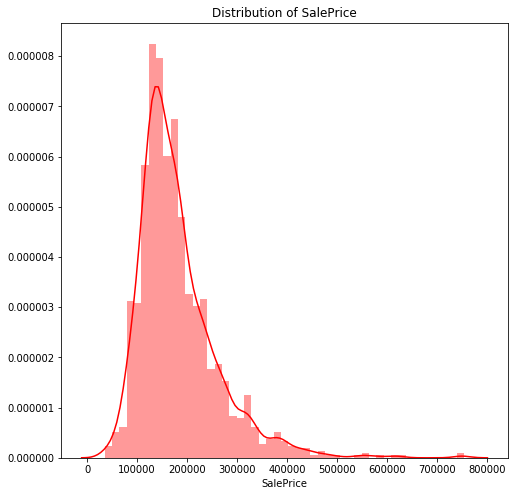

In [4]:
plt.figure(figsize=(8,8))
ax=sns.distplot(train['SalePrice'],color='red')
ax.set_xlabel('SalePrice')
ax.set_title('Distribution of SalePrice')

The distribution is a perfect normal curve with some outliers in the extremes.Lets check the median value of the sale price with respect to the year built.

In [ ]:
print("Train data has sale price from staring year {} to ending year {}".format(min(train['YearBuilt']),max(train['YearBuilt'])))

In [ ]:
print("Test data has sale price from staring year {} to ending year {}".format(min(test['YearBuilt']),max(test['YearBuilt'])))

In [ ]:
year_sale=train.groupby('YearBuilt')['SalePrice'].median()
year_sale.plot()

The sale price seem to be showing a fluctuating trend over the year.

The metric used for checking the model is rmsle .Therefore lets convert the sales price to log scale.

In [7]:
# train['SalePrice']=np.log1p(train['SalePrice'])

Text(0.5, 1.0, 'Distribution of SalePrice(Log Scale)')

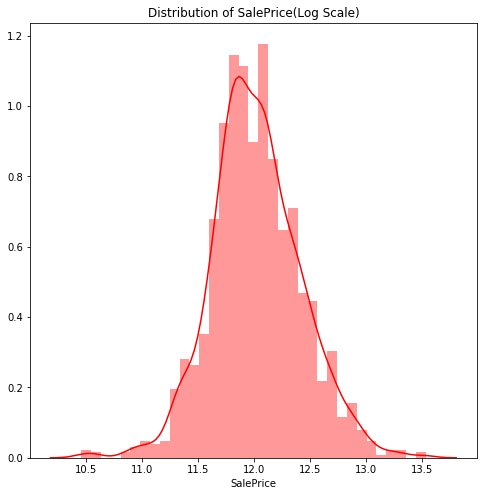

In [8]:
# plt.figure(figsize=(8,8))
# ax=sns.distplot(train['SalePrice'],color='red')
# ax.set_xlabel('SalePrice')
# ax.set_title('Distribution of SalePrice(Log Scale)')

The distribution is a perfect normal.

Lets check if there are any null values in the dataset.

In [9]:
train.isnull().values.any()

True

In [10]:
test.isnull().values.any()

True

Thus we see that there are columns both in train and test data having null values . The total number of rows present is 1460 . Therefore we consider a threashold of 500 and check the columns having more than 500 null values and remove them.

In [7]:
def check_null(df):
    null=df.isnull().sum()
    focus_columns=null[null>0]
    
    return(focus_columns)

In [8]:
focus_columns_train=check_null(train)
focus_columns_test=check_null(test)
print("Columns to focus in train dataset:\n {} \nColumns to focus in test dataset:\n {}".format(focus_columns_train,focus_columns_test))

Columns to focus in train dataset:
 LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 
Columns to focus in test dataset:
 MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish

Thus we see that there are 5 columns in train and test having null values in more than 500 rows . Lets remove them.

In [9]:
train_clean=train.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1)
test_clean=test.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1)

Other columns having null values need to be imputed before we build a basic model.Lets check the train dataset first.

In [10]:
impute_columns_train=focus_columns_train[focus_columns_train<500]
print("There are {} columns to be imputed \n The columns are \n{}".format(len(impute_columns_train),impute_columns_train.index))

There are 14 columns to be imputed 
 The columns are 
Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')


Lets check the description of these columns to decide on the imputing criteria.

In [104]:
train_clean[['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
LotFrontage     1201 non-null object
MasVnrType      1452 non-null category
MasVnrArea      1452 non-null object
BsmtQual        1423 non-null category
BsmtCond        1423 non-null category
BsmtExposure    1422 non-null category
BsmtFinType1    1423 non-null category
BsmtFinType2    1422 non-null category
Electrical      1459 non-null category
GarageType      1379 non-null category
GarageYrBlt     1379 non-null object
GarageFinish    1379 non-null category
GarageQual      1379 non-null category
GarageCond      1379 non-null category
dtypes: category(11), object(3)
memory usage: 52.0+ KB


Only 3 variables are numerical variables while others are categorical.We try to impute the missing values with median values in that column.

In [11]:
### Inspited from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
###https://www.kaggle.com/tunguz/more-effective-ridge-lgbm-script-lb-0-44341-2
for col in ['LotFrontage','MasVnrArea','GarageYrBlt']:
    train_clean[col]=train_clean[col].fillna(train_clean[col].median()).astype('float16')

All the other categorical variables except electrical can be imputed with NA since in the data description there is a separate category 'NA'.

In [12]:
for col in ['GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']:
    train_clean[col]=train_clean[col].cat.add_categories('NA')
    train_clean[col]=train_clean[col].fillna('NA')

In [107]:
train_clean['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Standard Circuit Breakers & Romex is the type most used for the electrical system and hence we impute that value.

In [13]:
train_clean['Electrical']=train_clean['Electrical'].fillna('SBrkr')

Now lets check if there are any more null values.

In [14]:
del impute_columns_train
del focus_columns_train
train_clean.isnull().values.any()

False

In [110]:
#train_clean.info()

Now lets take the test dataset and impute the missing values.

In [15]:
impute_columns_test=focus_columns_test[focus_columns_test<500]
print("There are {} columns to be imputed \n The columns are \n{}".format(len(impute_columns_test),impute_columns_test.index))

There are 28 columns to be imputed 
 The columns are 
Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')


In [112]:
test_clean[['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 28 columns):
MSZoning        1455 non-null category
LotFrontage     1232 non-null object
Utilities       1457 non-null category
Exterior1st     1458 non-null category
Exterior2nd     1458 non-null category
MasVnrType      1443 non-null category
MasVnrArea      1444 non-null object
BsmtQual        1415 non-null category
BsmtCond        1414 non-null category
BsmtExposure    1415 non-null category
BsmtFinType1    1417 non-null category
BsmtFinSF1      1458 non-null float32
BsmtFinType2    1417 non-null category
BsmtFinSF2      1458 non-null float32
BsmtUnfSF       1458 non-null float32
TotalBsmtSF     1458 non-null float32
BsmtFullBath    1457 non-null float32
BsmtHalfBath    1457 non-null float32
KitchenQual     1458 non-null category
Functional      1457 non-null category
GarageType      1383 non-null category
GarageYrBlt     1381 non-null object
GarageFinish    1381 non-null category
GarageCa

In [16]:
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','LotFrontage','MasVnrArea','GarageYrBlt']:
    test_clean[col]=test_clean[col].fillna(test_clean[col].median()).astype('float16')

In [17]:
for col in ['GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']:
    test_clean[col]=test_clean[col].cat.add_categories('NA')
    test_clean[col]=test_clean[col].fillna('NA')

The other columns - Exterior1st,Exterior2nd,Utilities,MSZoning,saletype,functional and Kitchen Qual do have have inherent NA value and hence they will be imputed with maximum value.

In [19]:
## https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

for col in ['Exterior1st','Exterior2nd','Utilities','MSZoning','SaleType','Functional','KitchenQual']:
    print(f'Imputing col {col} with {test_clean[col].value_counts().index[0]}')
    test_clean[col]=test_clean[col].fillna(test_clean[col].value_counts().index[0])

Imputing col Exterior1st with VinylSd
Imputing col Exterior2nd with VinylSd
Imputing col Utilities with AllPub
Imputing col MSZoning with RL
Imputing col SaleType with WD
Imputing col Functional with Typ
Imputing col KitchenQual with TA


In [20]:
test_clean.isnull().values.any()

False

In [117]:
#test_clean.info()

In [21]:
del train
del test

In [22]:

ntrain=train_clean.shape[0]
all_df=pd.concat([train_clean,test_clean])

In [23]:
for col in ['Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'GarageQual','Heating', 'HouseStyle', 'RoofMatl', 'Utilities']:
    print(f'Converting {col} from object to category datatype')
    all_df[col]=all_df[col].astype('category')

Converting Condition2 from object to category datatype
Converting Electrical from object to category datatype
Converting Exterior1st from object to category datatype
Converting Exterior2nd from object to category datatype
Converting GarageQual from object to category datatype
Converting Heating from object to category datatype
Converting HouseStyle from object to category datatype
Converting RoofMatl from object to category datatype
Converting Utilities from object to category datatype


In [24]:
categories = all_df.select_dtypes('category')

In [122]:
for  cat in categories:
    print(f'\n{cat} has {all_df[cat].nunique()} categories')


BldgType has 5 categories

BsmtCond has 5 categories

BsmtExposure has 5 categories

BsmtFinType1 has 7 categories

BsmtFinType2 has 7 categories

BsmtQual has 5 categories

CentralAir has 2 categories

Condition1 has 9 categories

Condition2 has 8 categories

Electrical has 5 categories

ExterCond has 5 categories

ExterQual has 4 categories

Exterior1st has 15 categories

Exterior2nd has 16 categories

Foundation has 6 categories

Functional has 7 categories

GarageCond has 6 categories

GarageFinish has 4 categories

GarageQual has 6 categories

GarageType has 7 categories

Heating has 6 categories

HeatingQC has 5 categories

HouseStyle has 8 categories

KitchenQual has 4 categories

LandContour has 4 categories

LandSlope has 3 categories

LotConfig has 5 categories

LotShape has 4 categories

MSZoning has 5 categories

MasVnrType has 5 categories

Neighborhood has 25 categories

OverallCond has 9 categories

OverallQual has 10 categories

PavedDrive has 3 categories

RoofMatl ha

In [25]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype.name == 'category']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [26]:
all_df,oh_new_cols=one_hot_encoder(all_df)

In [125]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 339 entries, 1stFlrSF to Utilities_nan
dtypes: float16(8), float32(14), float64(2), int64(10), int8(1), object(1), uint8(303)
memory usage: 1.4+ MB


In [126]:
# for col in categories:
#     print(f'Dropping column {col}')
#     all_df=all_df.drop([col],axis=1)

In [27]:
all_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,Street_Grvl,Street_Pave,Street_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan
0,856,854,0.0,3,706.0,0.0,1.0,0.0,150.0,0.0,...,0,0,1,0,0,1,0,1,0,0
1,1262,0,0.0,3,978.0,0.0,0.0,1.0,284.0,0.0,...,0,0,1,0,0,1,0,1,0,0
2,920,866,0.0,3,486.0,0.0,1.0,0.0,434.0,0.0,...,0,0,1,0,0,1,0,1,0,0
3,961,756,0.0,3,216.0,0.0,1.0,0.0,540.0,272.0,...,0,0,1,0,0,1,0,1,0,0
4,1145,1053,0.0,4,655.0,0.0,1.0,0.0,490.0,0.0,...,0,0,1,0,0,1,0,1,0,0


Thus all the columns have been encoded.Lets split the train and test back.

In [28]:
train=all_df[:ntrain]
train.shape

(1460, 339)

In [29]:
train.isnull().values.any()

False

In [30]:
test=all_df[ntrain:]
test.shape

(1459, 339)

In [31]:
test=test.drop(['SalePrice'],axis=1)

In [32]:
test.isnull().values.any()

False

In [33]:
test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,Street_Grvl,Street_Pave,Street_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan
0,896,0,0.0,2,468.0,144.0,0.0,0.0,270.0,0.0,...,0,0,1,0,0,1,0,1,0,0
1,1329,0,0.0,3,923.0,0.0,0.0,0.0,406.0,0.0,...,0,0,1,0,0,1,0,1,0,0
2,928,701,0.0,3,791.0,0.0,0.0,0.0,137.0,0.0,...,0,0,1,0,0,1,0,1,0,0
3,926,678,0.0,3,602.0,0.0,0.0,0.0,324.0,0.0,...,0,0,1,0,0,1,0,1,0,0
4,1280,0,0.0,2,263.0,0.0,0.0,0.0,1017.0,0.0,...,0,0,1,0,0,1,0,1,0,0


### Basic Modelling 

The metric used for modelling is RMSE score .Lets create a function to calculate the score.

In [34]:
def rmsle(x,y): return math.sqrt(((np.log1p(x)-np.log1p(y))**2).mean())

We notice that the train data has features of houses built between 1872 to 2010 whereas the test data has houses built between 1879 till 2010. Therefore an effective train-valid-test split would be to split based on this time based feature since it is a common fact that the house prices tend to depreciate as the house gets older and older.We take  1000 rows as train data and 460 rows as validation set.

In [35]:
train.sort_values('YearBuilt',inplace=True)

In [36]:
X=train.drop(['SalePrice'],axis=1)
y=train['SalePrice']

In [137]:
from sklearn.model_selection import KFold, StratifiedKFold

In [50]:
num_folds=5

In [51]:
folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)

We build a random forest model with the dataset and check the baseline accuracy.

In [ ]:
###https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize
###https://www.kaggle.com/humananalog/xgboost-lasso
###https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [52]:
oof_preds = np.zeros(train.shape[0])
feature_importance_df = pd.DataFrame()
sub_preds = np.zeros(test.shape[0])

In [53]:
feat=[f for f in X.columns if f in test.columns]

In [56]:
##https://www.kaggle.com/tunguz/xgb-simple-features
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X,y)):
        
            train_x, train_y = X[feat].iloc[train_idx], y.iloc[train_idx]
            valid_x, valid_y = X[feat].iloc[valid_idx], y.iloc[valid_idx]
            rfm = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True,random_state=100)
            rfm.fit(train_x, train_y)
            

            oof_preds[valid_idx] = rfm.predict(valid_x)[:1]
            sub_preds += rfm.predict(test[feat]) / folds.n_splits # - Uncomment for K-fold 

            fold_importance_df = pd.DataFrame()
            fold_importance_df["cols"] = X.columns
            fold_importance_df["importance"] = rfm.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmsle(valid_y, oof_preds[valid_idx])))
            del rfm, train_x, train_y, valid_x, valid_y
            gc.collect()

Fold  1 RMSE : 0.786200
Fold  2 RMSE : 0.435394
Fold  3 RMSE : 0.478439
Fold  4 RMSE : 0.385835
Fold  5 RMSE : 0.594068


In [78]:
pred_df = pd.DataFrame(sub_preds, index=test["Id"], columns=["SalePrice"])
#pred_df.to_csv('output.csv', header=True, index_label='Id')

The model scored 0.15915 on LB . Lets try to improve our model.

### Improving our model

One reason we are getting a high RMSLE error is due to presence of all the features .Lets build a RF model and check the permutation importance to know which features are useful in predicting the sale price.

In [38]:
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb

In [39]:
## From fast.ai library,
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
train_x,valid_x,train_y,valid_y=train_test_split(X,y,test_size=0.2,random_state=100)

In [41]:
print(f'Shape of train_x is {train_x.shape} Shape of train_y is {train_y.shape} Shape of valid_x is {valid_x.shape} Shape of valid_y is {valid_y.shape}')

Shape of train_x is (1168, 338) Shape of train_y is (1168,) Shape of valid_x is (292, 338) Shape of valid_y is (292,)


In [42]:
 rfm = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True,random_state=100)

In [44]:
rfm.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=100, verbose=0, warm_start=False)

In [45]:
print(f"RMSLE of the model {rmsle(valid_y,rfm.predict(valid_x))}")

RMSLE of the model 0.1524151730739201


In [73]:
perm = PermutationImportance(rfm, random_state=100).fit(valid_x,valid_y)
eli5.show_weights(perm, feature_names = valid_x.columns.tolist())

Weight,Feature
0.1951 ± 0.0357,GrLivArea
0.0842 ± 0.0188,YearBuilt
0.0217 ± 0.0058,TotalBsmtSF
0.0201 ± 0.0063,1stFlrSF
0.0157 ± 0.0109,Fireplaces
0.0131 ± 0.0037,GarageCars
0.0123 ± 0.0095,ExterQual_TA
0.0115 ± 0.0033,LotArea
0.0091 ± 0.0049,2ndFlrSF
0.0084 ± 0.0016,YearRemodAdd


From the permutation importance we see that GrLivArea (Above grade (ground) living area square feet) seems to be most important in predicting the sale price followed by year built and TotalBsmtSF . It is interesting to note that Fireplaces is also noted as important feature.The external material quality of average/typical is also rated as important factor.Lets take the weights till 0.0115 and build our model .Lets check if there is any improvement in our predictions.

In [50]:
to_keep=['GrLivArea','YearBuilt','TotalBsmtSF','1stFlrSF','Fireplaces','GarageCars','ExterQual_TA','LotArea']

In [51]:
X_keep=X[to_keep].copy()

In [52]:
train_x,valid_x,train_y,valid_y=train_test_split(X_keep,y,test_size=0.2)

In [53]:
print(f'Shape of train_x is {train_x.shape} Shape of train_y is {train_y.shape} Shape of valid_x is {valid_x.shape} Shape of valid_y is {valid_y.shape}')

Shape of train_x is (1168, 8) Shape of train_y is (1168,) Shape of valid_x is (292, 8) Shape of valid_y is (292,)


Lets try random forest model without cv again.

In [99]:
rfm = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True,random_state=100)

In [100]:
rfm.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=100, verbose=0, warm_start=False)

In [101]:
oof_rfm=rfm.predict(valid_x)

In [64]:
print(f"RMSLE of the model {rmsle(valid_y,rfm.predict(valid_x))}")

RMSLE of the model 0.1754679259949842


The RMSE is too high .Lets try LGBM .

In [113]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 3, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [67]:
train_lgb=lgb.Dataset(train_x,label=train_y)
valid_lgb=lgb.Dataset(valid_x,label=valid_y)

In [114]:
#https://www.kaggle.com/ashishpatel26/hyper-parameter-tuning-code-for-lightgbm

num_round=5000
clf = lgb.train(param, train_lgb, num_round,valid_sets=[train_lgb,valid_lgb], verbose_eval=100,early_stopping_rounds=200)
oof_lgb= clf.predict(valid_x, num_iteration=clf.best_iteration)

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 39690.3	valid_1's rmse: 47081.9
[200]	training's rmse: 21989.7	valid_1's rmse: 35335.2
[300]	training's rmse: 13894.8	valid_1's rmse: 31990.1
[400]	training's rmse: 9862.85	valid_1's rmse: 31180.3
[500]	training's rmse: 7505.18	valid_1's rmse: 30775.3
[600]	training's rmse: 5893.31	valid_1's rmse: 30524.8
[700]	training's rmse: 4736.36	valid_1's rmse: 30343.1
[800]	training's rmse: 3898.62	valid_1's rmse: 30282.1
[900]	training's rmse: 3259.2	valid_1's rmse: 30200.5
[1000]	training's rmse: 2744.59	valid_1's rmse: 30140.5
[1100]	training's rmse: 2366.44	valid_1's rmse: 30108.2
[1200]	training's rmse: 2040.63	valid_1's rmse: 30089
[1300]	training's rmse: 1788.83	valid_1's rmse: 30077.9
[1400]	training's rmse: 1579.91	valid_1's rmse: 30065.6
[1500]	training's rmse: 1416.45	valid_1's rmse: 30063.7
[1600]	training's rmse: 1275.9	valid_1's rmse: 30057.4
[1700]	training's rmse: 1161.34	valid_1's rmse: 30051.

In [115]:
print(f"RMSLE of the model {rmsle(valid_y,oof_lgb)}")

RMSLE of the model 0.1792698505184241


In [116]:
predictions=clf.predict(test[to_keep])

In [117]:
pred_df = pd.DataFrame(predictions, index=test["Id"], columns=["SalePrice"])

In [118]:
pred_df.head()

,SalePrice
Id,
1461,117471.068649
1462,126097.186379
1463,189483.975295
1464,178944.940733
1465,185876.673350


In [ ]:
pred_df.to_csv('output.csv', header=True, index_label='Id')